In [ ]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from networkx import from_numpy_matrix, to_numpy_matrix, set_node_attributes

from tqdm.notebook import tqdm
from datetime import datetime

from custom_metrics import calculate_modularity, interpolation_quality
from graph_generator import generate_time_series, generate_random_mu
from interpolation import interpolate_time_series, interpolate_single_graph

from custom_modularity import custom_modularity

In [ ]:
G1, G2 = generate_time_series([0.3, 0.4])
t1, t, t2 = 0, 1, 2

G = interpolate_single_graph(G1, G2, t1, t2, t)

In [ ]:
alpha = (t - t1) / (t2 - t1) if t2 != t1 else 0

Функция, расчитывающая разницу между модулярностью в момент времени $t$ и линейной комбинацией модулярностей в моменты времени $t-1$ и $t+1$:
$$f = Q_t - (1-α)Q_{t-1} - \alpha Q_{t+1}$$

In [ ]:
from custom_modularity import calculate_k, calculate_Q, calculate_delta

In [ ]:
def difference_in_modularity(A, n, delta, Q1, Q2, alpha):
    k = calculate_k(A, n)
    Q = calculate_Q(A, k, n, delta)

    return abs(Q - (1-alpha)*Q1 - alpha*Q2)

Согласно теории, эта величина должна быть равной дифференциальной модулярности

In [ ]:
from custom_modularity import calculate_differential_modularity

In [ ]:
A = to_numpy_matrix(G)
n = A.shape[0]

communities = {frozenset(G.nodes[v]["community"]) for v in G}
delta = calculate_delta(communities, n)

Q1 = custom_modularity(G1)
Q2 = custom_modularity(G2)

print(difference_in_modularity(A, n, delta, Q1, Q2, alpha))
print(calculate_differential_modularity(G1, G2, alpha))

0.0005037250699915369
0.000503725069991633


Модифицируем процесс интерполяции: после вычисления весов как линейной комбинации будем добавлять величину X, после чего выполним нормализацию

In [ ]:
X = np.mean(A) + np.zeros((n, n))

In [ ]:
A_new = A + X
m = np.sum(A_new) / 2
A_new = A_new / m

In [ ]:
difference_in_modularity(A_new, n, delta, Q1, Q2, alpha)

0.03824370510936449

Видим, что разница изменилась. Теперь будем оптимизировать величину разницу в модулярности в зависимости от X

In [ ]:
from scipy.optimize import dual_annealing, differential_evolution

In [ ]:
from custom_modularity import custom_modularity, calculate_k, calculate_Q, calculate_delta
from scipy.optimize import dual_annealing


Q1 = custom_modularity(G1)
Q2 = custom_modularity(G2)
Q_diff = calculate_differential_modularity(G1, G2, alpha)

A = to_numpy_matrix(G)
n = A.shape[0]
A = A.reshape(n**2)

communities = {frozenset(G.nodes[v]["community"]) for v in G}
delta = calculate_delta(communities, n)

def difference_in_modularity(A, n, delta, Q1, Q2, alpha):
    k = calculate_k(A, n)
    Q = calculate_Q(A, k, n, delta)

    return abs(Q - (1-alpha)*Q1 - alpha*Q2)

def f_target(X, A, n, delta, Q1, Q2, alpha=0.5):
    A_new = A + X
    m = np.sum(A_new) / 2
    A_new = A_new / m

    A_new = A_new.reshape(n, n)

    return difference_in_modularity(A_new, n, delta, Q1, Q2, alpha)


optimization_stat = []
def callback(x, f, context):
    optimization_stat.append((datetime.now(), f))

    return f < 1e-8

left_bound = np.min(A)
right_bound = np.max(A)
bounds = [(left_bound, right_bound) for _ in range(n**2)]

res = dual_annealing(f_target,
                     bounds=bounds,
                     args=(A, n, delta, Q1, Q2),
                     callback=callback,
                     maxiter=500
                     )

In [ ]:
#pd.DataFrame(res.x, columns=['X']).to_csv('X.csv', index=False)
stats = pd.DataFrame({'time': [step[0] for step in optimization_stat], 
                      'f_value': [step[1] for step in optimization_stat]})
stats.to_csv('optimization_stats.csv', index=False)

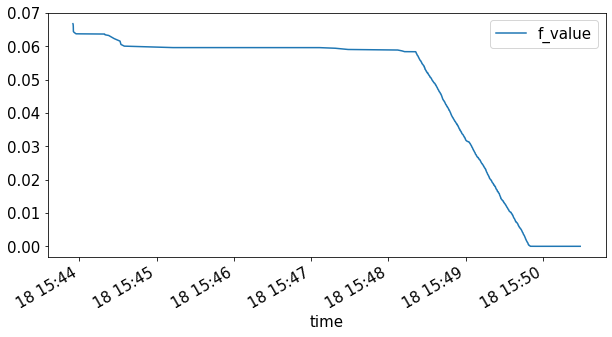

In [ ]:
plt.rcParams['figure.figsize'] = [10, 5]
stats.plot(x='time', y='f_value')

In [ ]:
A_new = A.reshape(n, n) + res.x.reshape(n, n)
m = np.sum(A_new) / 2
A_new = A_new / m
G_new = from_numpy_matrix(A_new)

com_dict = dict([(v, G.nodes[v]["community"]) for v in G])
set_node_attributes(G_new, com_dict, "community")

k = calculate_k(A_new, n)
Q = calculate_Q(A_new, k, n, delta)

In [ ]:
difference_in_modularity(A_new, n, delta, Q1, Q2, alpha)

1.557420026276901e-10